In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_breast_cancer()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [2]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 
# Select only the desired features
data_X = X[['mean radius', 'mean concave points']].to_numpy()

# Encode y to be +1 and -1
le = LabelEncoder()
data_y = le.fit_transform(y)
data_y[data_y == 0] = -1  # Replace 0 with -1

[Text(0.5, 0, 'mean radius'), Text(0, 0.5, 'mean concave points')]

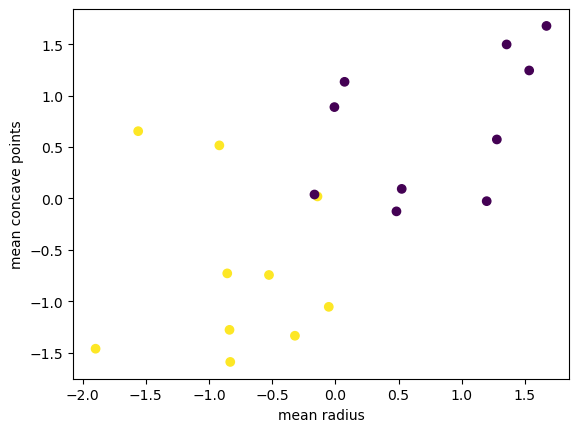

In [3]:
n = 20
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='mean radius', ylabel='mean concave points')

In [4]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    plt.legend()
    #plt.title('Soft Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['CVX Solution', 'ODE Solution', 'Malignant', 'Benign']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    #plt.title('SVM Decision Boundaries')
    plt.show()
    
def plot_svm_decision_boundary_confrontation_PINN(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['ODE Solution', 'PINN Solution', 'Malignant', 'Benign']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    #plt.title('SVM Decision Boundaries')
    plt.show()

In [5]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b']
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

In [6]:
def hyperplane_similarity(w, b, w_opt, b_opt, alpha=0.5, beta=0.5):
    """
    Computes a metric to measure the similarity between two hyperplanes defined by (w, b) and (w_opt, b_opt).
    
    Parameters:
    - w (np.ndarray): Normal vector of the first hyperplane.
    - b (float): Offset of the first hyperplane.
    - w_opt (np.ndarray): Normal vector of the optimal hyperplane.
    - b_opt (float): Offset of the optimal hyperplane.
    - alpha (float): Weight for the angular difference metric. Default is 0.5.
    - beta (float): Weight for the offset difference metric. Default is 0.5.
    
    Returns:
    - float: Combined metric value. Closer to 0 indicates more similar hyperplanes.
    """
    # Normalize vectors for angle computation
    norm_w = np.linalg.norm(w)
    norm_w_opt = np.linalg.norm(w_opt)
    
    # Handle edge cases for zero vectors
    if norm_w == 0 or norm_w_opt == 0:
        raise ValueError("The normal vector of a hyperplane cannot be a zero vector.")
    
    # Compute cosine similarity and angle metric
    cos_theta = np.dot(w, w_opt) / (norm_w * norm_w_opt)
    angle_metric = 1 - cos_theta
    
    # Normalize vectors to unit length for offset comparison
    w_unit = w / norm_w
    w_opt_unit = w_opt / norm_w_opt
    
    # Compute the offset difference metric
    offset_diff = abs(b / norm_w - b_opt / norm_w_opt)
    offset_metric = offset_diff / max(abs(b / norm_w), abs(b_opt / norm_w_opt), 1)
    
    # Combine metrics
    combined_metric = alpha * angle_metric + beta * offset_metric
    return combined_metric

# CVX

Time: 0.0942230224609375
Optimal objective value: 22.63453163455317
SCS solver iterations: 225
SCS solve time: 0.028150428
SCS setup time: 0.037480842
Optimal w:  [-1.90879094 -1.05297519]
Optimal b:  [-0.20938658]
Dual variables (Lagrange multipliers): [ 0.          2.505326    0.          0.          0.          1.57592649
  0.         10.00000012  9.99999993  0.          0.          0.
  0.92939902  0.          0.          0.          0.          0.
  0.          0.        ]
Constraints: [-0.5770188   0.0000009  -0.309607   -0.80719393 -1.7351696  -0.00000056
 -0.54229206  0.9600763   1.0657649  -3.4476917  -2.2528636  -3.9516857
 -0.00000082 -1.4677304  -2.0521905  -0.1302394  -1.1911539  -4.164977
 -3.3732624  -1.0808289  -0.00000006 -0.00000037  0.         -0.00000006
 -0.00000005  0.00000021 -0.00000001 -0.96007603 -1.0657651   0.00000002
  0.00000003 -0.00000004  0.00000031  0.00000003 -0.00000004  0.00000008
 -0.00000005  0.00000001  0.00000002 -0.00000005]


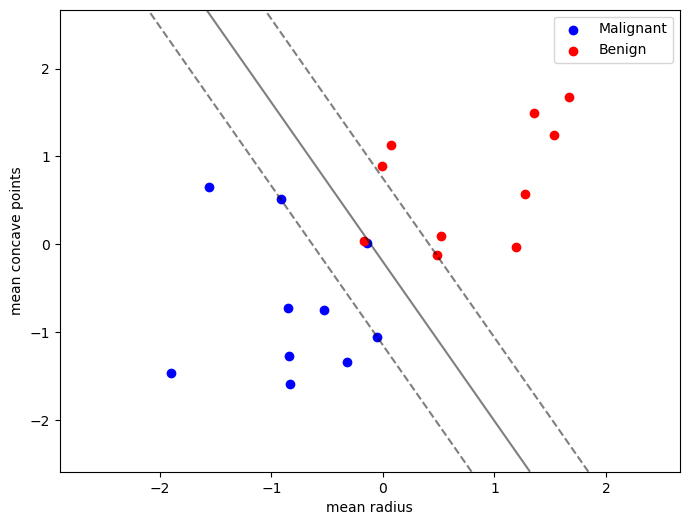

In [7]:
import cvxpy as cp
import numpy as np
import time

C = 10

num_features = selected_X.shape[1]

w = cp.Variable(num_features)
b = cp.Variable(1)
xi = cp.Variable(selected_y.shape[0])

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2 + C * cp.sum(xi))

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1 - xi,
    xi >= 0
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g_1 = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_2 = [np.array([-xi.value[i]]) for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g_1 + g_2).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

wb_cvx = np.concatenate([w.value, b.value])

# ODE

In [8]:
nw = selected_X.shape[1]
nb = 1
nxi = selected_y.shape[0]
nx = nw + nb + nxi
nu = selected_X.shape[0] * 2
NY = nx+nu

def f(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    output = (1/2) * jnp.linalg.norm(w, 2)**2 + C * jnp.sum(xi)
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    g_1 = [-selected_y[i] * (w @ selected_X[i] + b) + 1 - xi[i] for i in range(selected_y.shape[0])]
    g_2 = [- xi[i] for i in range(selected_y.shape[0])]
    output = jnp.array(g_1 + g_2)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)


In [9]:

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.01).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def evaluation_plus(xu):
    x, u= xu[:nx], xu[nx:]
    lim = None
    if (g(x)<=0.001).all():
        lim = 0.001
    elif (g(x)<=0.01).all():
        lim = 0.01
    elif (g(x)<=0.1).all():
        lim = 0.1
    elif (g(x)<=1).all():
        lim = 1
    return f(x), lim


In [10]:
def solve_ODE(xuv0, T):
    t0 = time.time()
    sol = solve_ivp(ODE, [0., T], xuv0, method=NUMERICAL_METHOD)
    solve_time = time.time() - t0
    print('Time:', solve_time)
    result = P(sol.y[:, -1])
    
    obj, lim = evaluation_plus(result)
    print("objective:", obj, "lim:", lim)
    
    print("objective:", obj)
    print("w: ", result[:nw], "b: ", result[nw])
    wb_ode = result[:nw+nb]
    similarity = hyperplane_similarity(result[:nw], result[nw], wb_cvx[:nw], wb_cvx[nw])
    print("hyperplane similarity:", similarity)
    print("Dual variables (alpha):", result[:nx])
    print("Constraints:",g(result[:nx]))
    
    return sol, result, obj, lim, similarity

# PINN

In [11]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i >= 1000 and all(x < 0.01 for x in L_loss[-5:]):
                break
            
            if i==ITERATIONS:
                break

        curr_net = deepcopy(net)
        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, curr_net, L_loss, time.time()-t0, i

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*(t / T).detach().reshape((-1, )))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        return dynamics_loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]

# Runs

In [12]:
def iteration(ip):
    xu0 = jnp.array(ip)
    y0 = ip
    
    # ODE Solution
    sol, result, obj, lim, similarity = solve_ODE(xu0, T)
    
    if lim == None:
        print('>>> Infeasible')
    else:
        print('>>> Feasible with epsilon:', lim, 'objective:', obj)

    print("hyperplane similarity:", similarity)
    if similarity < 0.01:
        print('>>> ODE Solution is accurate, last iteration')
        lastIter = True
    else:
        lastIter = False
        
    t_values = sol.t
    y_values = sol.y

    w_ode = result[:data_X.shape[1]]
    b_ode = result[data_X.shape[1]]

    plot_ode_system(t_values, y_values)

    plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)
    
    example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
    L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, net_curr, L_loss, t, n_iter = example.NN_method() # train
    print('epsilon:', L_epsilon[-1], 'time:', t, 'iterations:', n_iter)
    
    # ------------ NN plots ------------ 
    plt.plot(L_epsilon, marker='o', linestyle='-', label='OuC metric best', markersize=1)
    plt.plot(L_epsilon_curr, marker='o', linestyle='-', label='OuC metric current', markersize=1)
    plt.xlabel('iteration')
    plt.ylabel('OuC metric')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)

    plt.tight_layout()
    # Show the plot
    plt.show()
    
    print('Last losses:', L_loss[-10:])

    plt.plot(L_loss, label='Loss')
    plt.xlabel('iteration')
    plt.ylabel('Loss')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)
    plt.tight_layout()
    # Show the plot
    plt.show()
    
    if n_iter != ITERATIONS and lastIter:
        print('>>> NN Solution is accurate, last iteration')
        net = net_curr
        lastIter = True
    else:
        lastIter = False
        net = net_curr
    
    res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
    plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)
    print('Variables:', res[:nx])
    print('Constraints:', g(res[:nx]))
    
    pinn_obj, lim_pin = evaluation_plus(res)
    
    print("objective pinn:", pinn_obj, "epsion pinn:", lim_pin)
    
    print("w: ", res[:nw], "b: ", res[nw])

    similarity_pinn = hyperplane_similarity(res[:nw], res[nw], wb_cvx[:nw], wb_cvx[nw])
    print("PINN hyperplane similarity:", similarity_pinn)
    
    return res, pinn_obj, lastIter

In [13]:
NBATCH = 512
WEIGTHING = 1
LAYERS = 2
NEURONS = 100
LR = 0.001
T = 20.0

>>>> ITERATION: 1


Time: 2.365901470184326


objective: 17.71201 lim: 1
objective: 17.71201
w:  [-1.95387241 -1.03458207] b:  -0.02138973935387097
hyperplane similarity: 0.04326126404008933
Dual variables (alpha): [-1.95387241 -1.03458207 -0.02138974  0.00001691  0.08052248 -0.00070436
  0.00044307  0.00049229 -0.08179913  0.00024261  0.38532804  1.21772022
  0.00049181  0.00049086  0.00049292 -0.11560633  0.00048077  0.00049303
  0.03585036  0.00048296  0.00049178  0.00049225  0.0003795 ]
Constraints: [-0.7750422   0.08338305 -0.14285721 -0.98551947 -1.9379432  -0.08917934
 -0.33695066  0.37999848  0.04421008 -3.3064394  -2.1124103  -4.198873
 -0.12328663 -1.3346802  -2.2489605   0.03859795 -1.4048213  -4.021931
 -3.2193077  -1.351608   -0.00001691 -0.08052248  0.00070436 -0.00044307
 -0.00049229  0.08179913 -0.00024261 -0.38532802 -1.2177203  -0.00049181
 -0.00049086 -0.00049292  0.11560633 -0.00048077 -0.00049303 -0.03585036
 -0.00048296 -0.00049178 -0.00049225 -0.0003795 ]
>>> Feasible with epsilon: 1 objective: 17.71201
hype

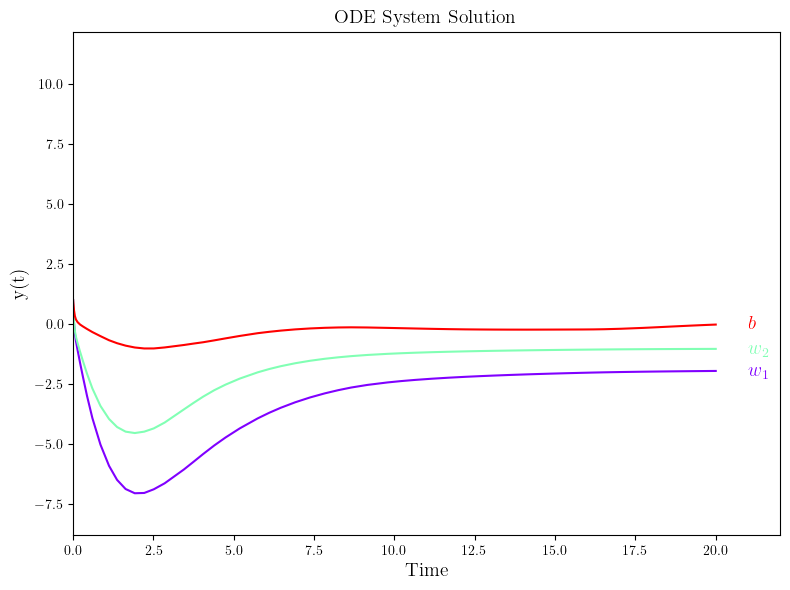

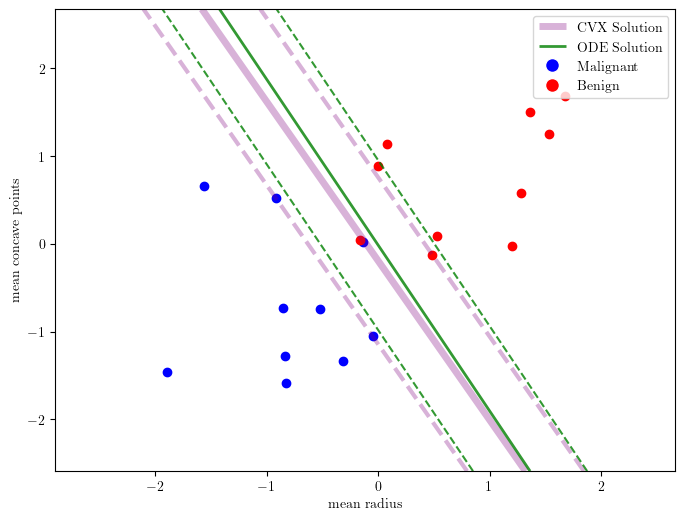

epsilon: 150.63963 time: 243.13676643371582 iterations: 2000


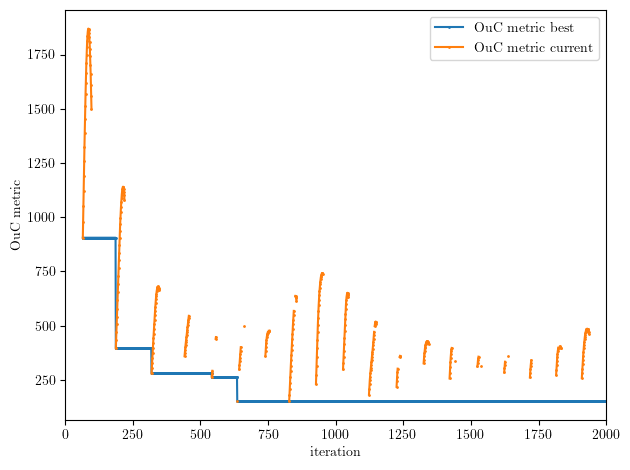

Last losses: [50.24814224243164, 51.803306579589844, 53.915985107421875, 55.70994567871094, 56.09998321533203, 57.00117492675781, 58.69916534423828, 58.280372619628906, 58.576866149902344, 59.01194763183594]


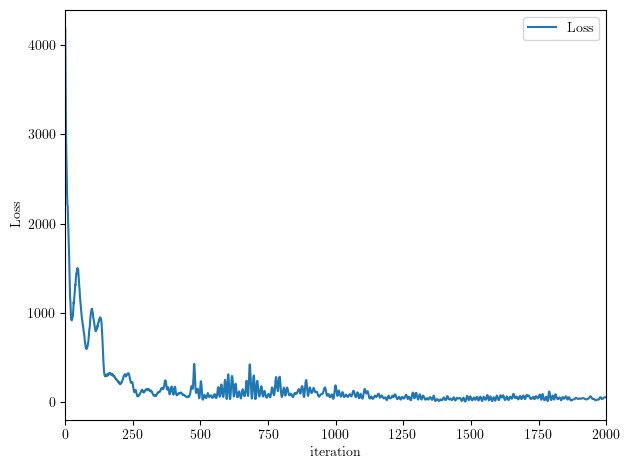

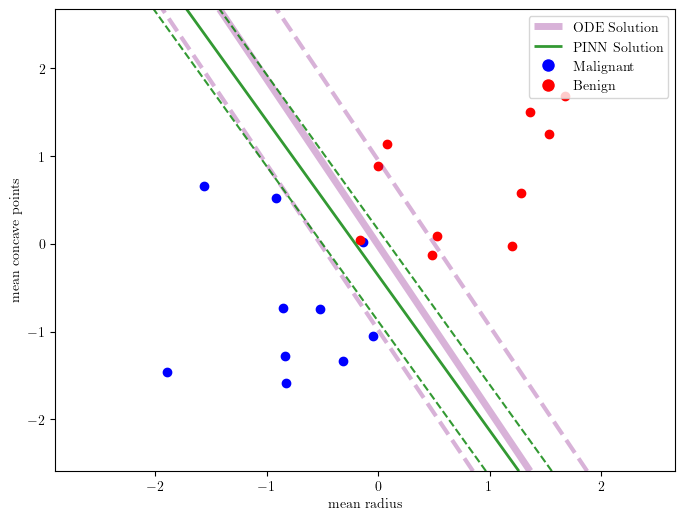

Variables: [-3.3847914  -1.9179742  -0.7016156  -0.16837966 -0.51141757 -0.35952464
  0.2594614   0.4366915   0.6217282  -0.17746302  1.9173234   1.9609096
  0.34447554  0.35117888  0.36226037 -0.12963384  0.46357182  0.3833654
  0.26505315  0.2869199   0.34217244  0.34632632 -0.7334728 ]
Constraints: [-1.3355409  -0.5858029  -1.2978063  -2.2015398  -4.0214033  -1.1181692
 -1.9453303  -0.656786   -1.1765689  -7.62492    -5.478821   -7.8867555
 -0.28710625 -4.1685038  -4.5460725  -1.6446953  -2.8790743  -8.91654
 -7.5076327  -1.5928426   0.16837966  0.51141757  0.35952464 -0.2594614
 -0.4366915  -0.6217282   0.17746302 -1.9173234  -1.9609096  -0.34447554
 -0.35117888 -0.36226037  0.12963384 -0.46357182 -0.3833654  -0.26505315
 -0.2869199  -0.34217244 -0.34632632  0.7334728 ]
objective pinn: 70.1832 epsion pinn: 1
w:  [-3.3847914 -1.9179742] b:  -0.7016156
PINN hyperplane similarity: 0.04217939895795711
>>>> ITERATION: 2


Time: 0.21309900283813477
objective: 22.755878 lim: 0.1
objective: 22.755878
w:  [-1.84884723 -0.98926521] b:  -0.19890489520349044
hyperplane similarity: 0.0006372848756791213
Dual variables (alpha): [-1.84884723 -0.98926521 -0.1989049  -0.00011805  0.01266781 -0.00003979
 -0.00012853 -0.00014548  0.03253415 -0.00012775  0.97861963  1.06019711
 -0.0001373  -0.00014474 -0.00013538  0.0082378  -0.00014007 -0.00014336
 -0.03475404 -0.00012237 -0.00014214 -0.00014181 -0.00009198]
Constraints: [-0.50848824  0.01880446 -0.26167735 -0.71332026 -1.6138949   0.02724874
 -0.45506975 -0.02180819  0.00859152 -3.2658336  -2.1290746  -3.7551925
  0.00344152 -1.3869871  -1.9114059  -0.02885876 -1.1038096  -3.9473188
 -3.1859848  -1.0393505   0.00011805 -0.01266781  0.00003979  0.00012854
  0.00014548 -0.03253415  0.00012775 -0.97861964 -1.0601971   0.0001373
  0.00014474  0.00013538 -0.0082378   0.00014007  0.00014336  0.03475404
  0.00012237  0.00014214  0.00014181  0.00009198]
>>> Feasible with ep

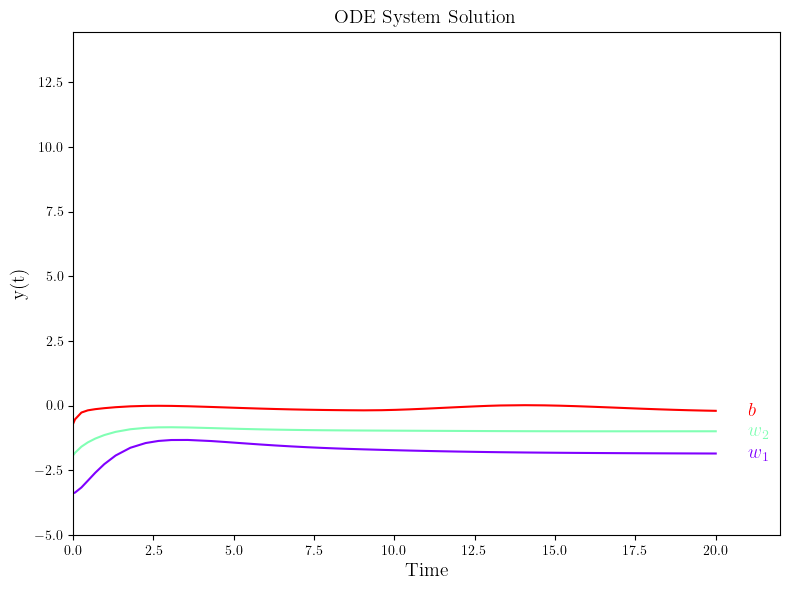

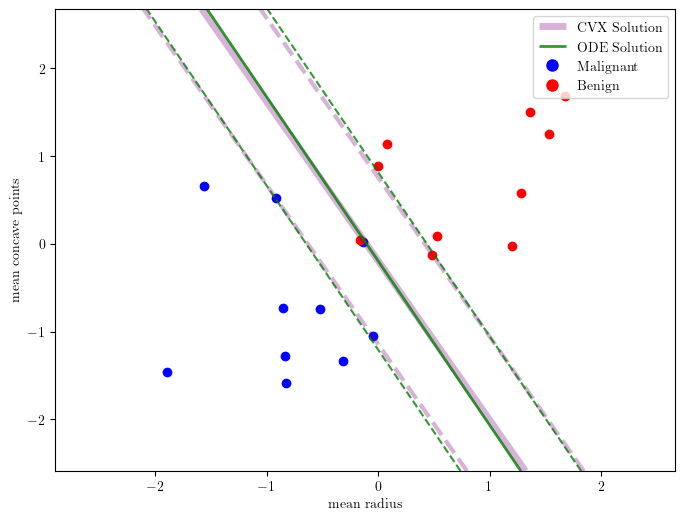

epsilon: 215.21172 time: 1171.2749156951904 iterations: 10000


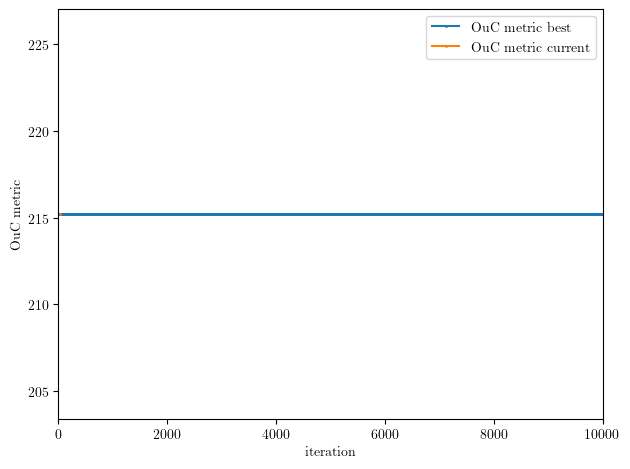

Last losses: [4.827203750610352, 5.233651161193848, 5.188718795776367, 4.645864963531494, 3.949371099472046, 2.9767305850982666, 2.155338764190674, 1.3710787296295166, 0.7604939341545105, 0.40381744503974915]


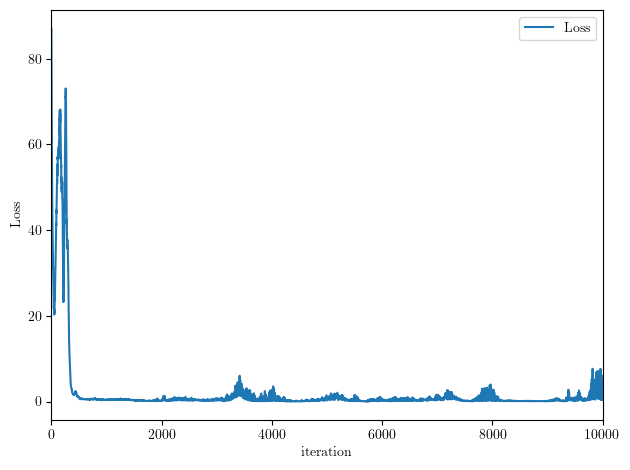

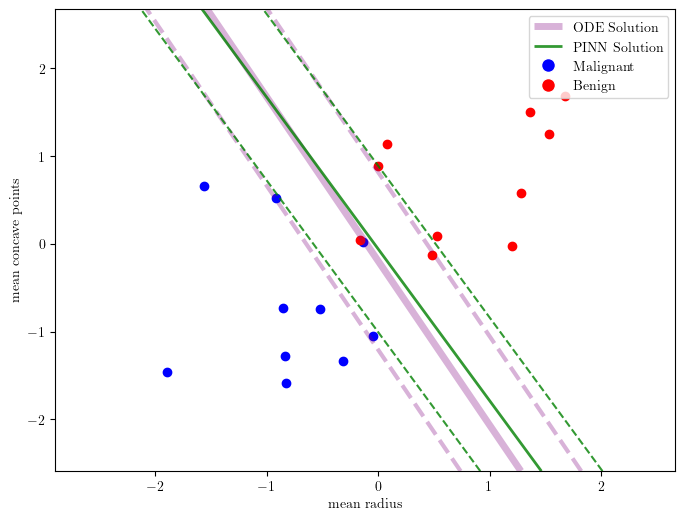

Variables: [-1.8251184  -1.0561141  -0.06718802 -0.00258763  0.1757049   0.04881936
 -0.04115561 -0.2851958  -0.23994529 -0.13046913  0.55141485  1.7009573
 -0.04144946 -0.1554445  -0.267527   -0.21224192 -0.16810766 -0.23834002
  0.1526369  -0.04707819 -0.10695264 -0.0367265  -0.11182815]
Constraints: [-0.67499214  0.00732696 -0.17259526 -0.88563496 -1.526064    0.09882016
 -0.26710758  0.27837688 -0.5069583  -3.1396139  -1.8500991  -3.67213
  0.14850365 -1.0571426  -1.8914175  -0.14411288 -1.2169486  -3.7813013
 -3.0856416  -0.9785447   0.00258763 -0.1757049  -0.04881936  0.04115561
  0.2851958   0.23994529  0.13046913 -0.55141485 -1.7009573   0.04144946
  0.1554445   0.267527    0.21224192  0.16810766  0.23834002 -0.1526369
  0.04707819  0.10695264  0.0367265   0.11182815]
objective pinn: 7.6680565 epsion pinn: 1
w:  [-1.8251184 -1.0561141] b:  -0.067188025
PINN hyperplane similarity: 0.03219852803295356
>>>> ITERATION: 3
Time: 0.183457612991333


objective: 22.539783 lim: 0.1
objective: 22.539783
w:  [-1.86550739 -0.99373889] b:  -0.1756507035270896
hyperplane similarity: 0.0065279371822103485
Dual variables (alpha): [-1.86550739 -0.99373889 -0.1756507   0.00000157  0.02353138  0.00000396
  0.00000801  0.0000076   0.01549461  0.00000776  0.93169669  1.0942065
  0.00000013  0.0000123   0.00001262 -0.01224014  0.00001466  0.00000595
 -0.02220431  0.00001003  0.0000068   0.00001057  0.00000963]
Constraints: [-0.5439453   0.02370361 -0.24763002 -0.7480164  -1.6569778   0.01544816
 -0.43823507 -0.00040974  0.00041997 -3.2738383  -2.1298342  -3.816751
 -0.01232526 -1.3837218  -1.955781   -0.02200061 -1.1447132  -3.9595532
 -3.1921616  -1.0857825  -0.00000157 -0.02353138 -0.00000396 -0.00000801
 -0.0000076  -0.01549461 -0.00000776 -0.9316967  -1.0942065  -0.00000013
 -0.0000123  -0.00001262  0.01224014 -0.00001466 -0.00000595  0.02220432
 -0.00001003 -0.0000068  -0.00001057 -0.00000963]
>>> Feasible with epsilon: 0.1 objective: 22.539

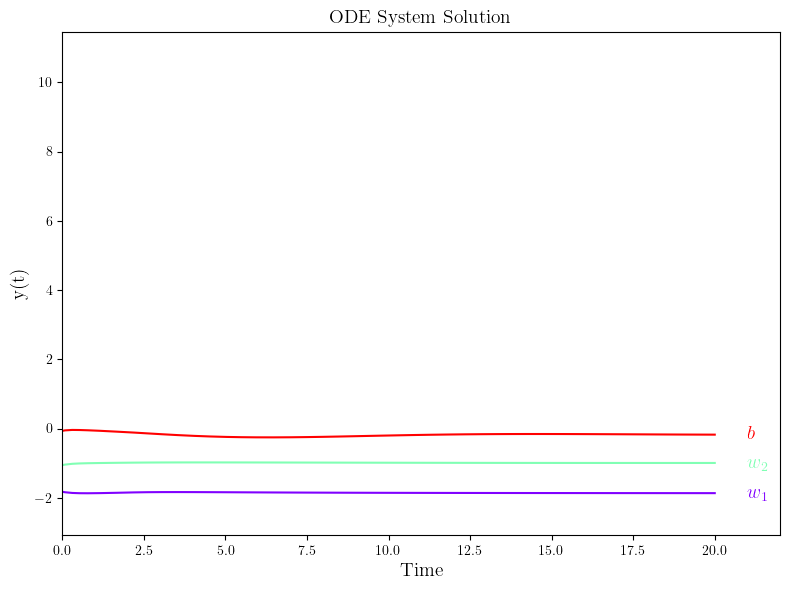

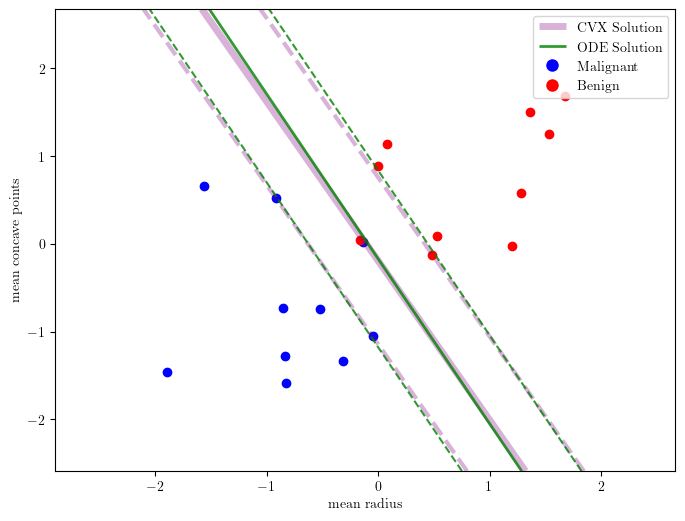

epsilon: inf time: 1157.6416068077087 iterations: 10000


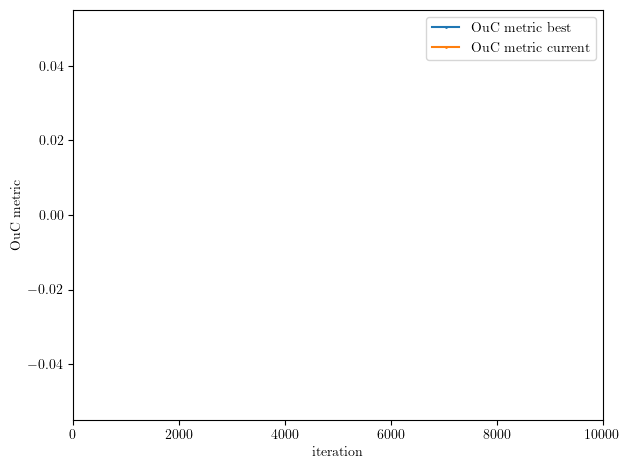

Last losses: [0.1774434745311737, 0.1848529875278473, 0.19211909174919128, 0.19539695978164673, 0.1971069574356079, 0.18955853581428528, 0.18264883756637573, 0.1676473617553711, 0.15556567907333374, 0.15374697744846344]


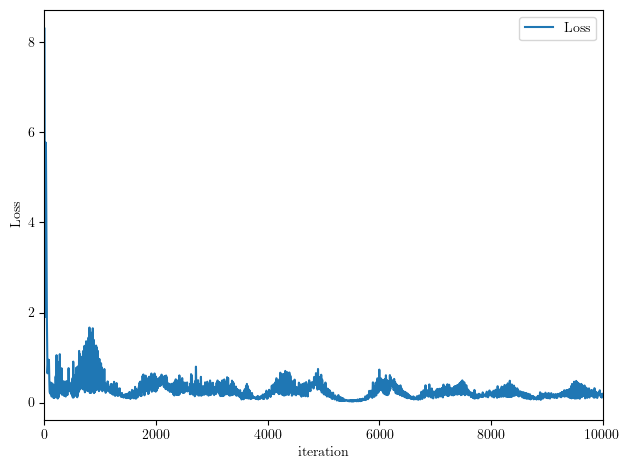

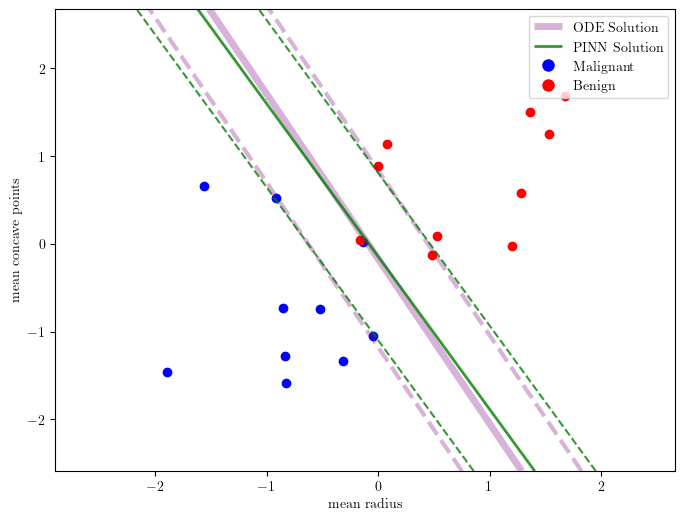

Variables: [-1.8272281  -1.0501884  -0.15736456 -0.05912424  0.06526519 -0.00202581
  0.05760753 -0.09240808 -0.1002937  -0.0542433   0.7569401   1.1980996
  0.07200575  0.0804814  -0.11503673 -0.07945882 -0.07918848 -0.02990839
  0.08434459 -0.06198689  0.05593298  0.04067463  0.02483934]
Constraints: [-0.52497977  0.02582818 -0.21248166 -0.8869881  -1.6228741   0.05547805
 -0.42694232  0.16261089 -0.09369939 -3.3391058  -2.1754968  -3.729792
  0.10090081 -1.2389193  -2.002011   -0.16071573 -1.1093533  -4.0279465
 -3.2472038  -1.0322065   0.05912424 -0.06526519  0.00202581 -0.05760753
  0.09240808  0.1002937   0.0542433  -0.7569401  -1.1980996  -0.07200575
 -0.0804814   0.11503673  0.07945882  0.07918848  0.02990839 -0.08434459
  0.06198689 -0.05593298 -0.04067463 -0.02483934]
objective pinn: 19.845997 epsion pinn: 1
w:  [-1.8272281 -1.0501884] b:  -0.15736456
PINN hyperplane similarity: 0.01076814398122225
>>>> ITERATION: 4


Time: 0.20135021209716797
objective: 22.524082 lim: 0.1
objective: 22.524082
w:  [-1.86766663 -0.99456238] b:  -0.17137844534590171
hyperplane similarity: 0.007583491889396735
Dual variables (alpha): [-1.86766663 -0.99456238 -0.17137845 -0.0000025   0.02573295  0.00000146
 -0.00000644 -0.00000309  0.01238482  0.00000239  0.92451143  1.10144409
  0.00000086 -0.00000504  0.00000277 -0.01563739  0.00000815  0.00000357
 -0.01988736 -0.00000493 -0.00000243 -0.00000131 -0.0000007 ]
Constraints: [-0.54996085  0.0248339  -0.24456556 -0.75406474 -1.6641006   0.01330498
 -0.43504825  0.0022139  -0.00221992 -3.2739036  -2.1287766  -3.8263147
 -0.01475812 -1.3820072  -1.9631562  -0.02076032 -1.1514182  -3.9602606
 -3.192037   -1.0928758   0.0000025  -0.02573295 -0.00000146  0.00000644
  0.00000309 -0.01238482 -0.00000239 -0.92451143 -1.1014441  -0.00000086
  0.00000504 -0.00000277  0.01563739 -0.00000815 -0.00000357  0.01988736
  0.00000493  0.00000243  0.00000131  0.0000007 ]
>>> Feasible with ep

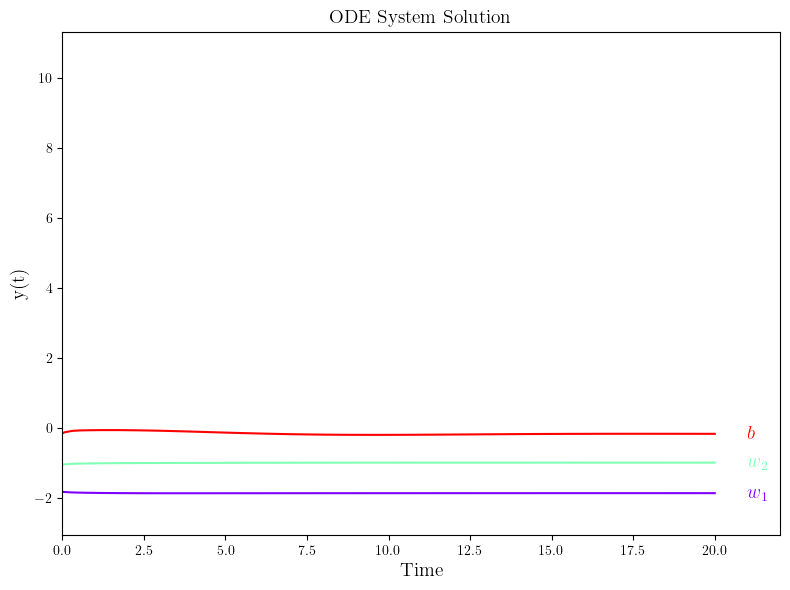

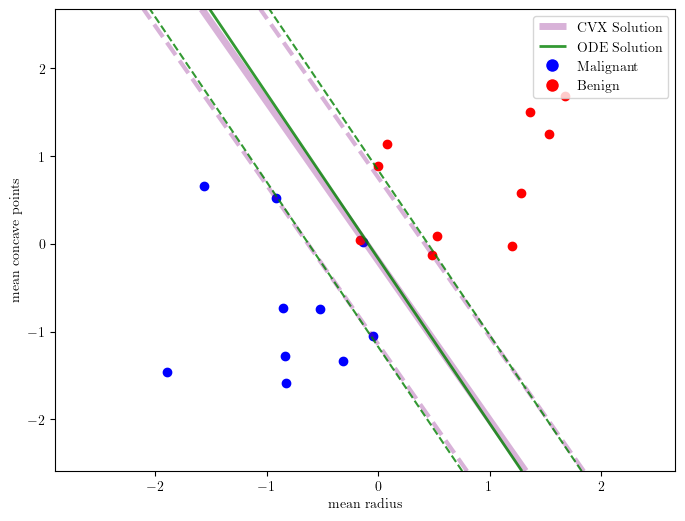

epsilon: inf time: 1206.5591495037079 iterations: 10000


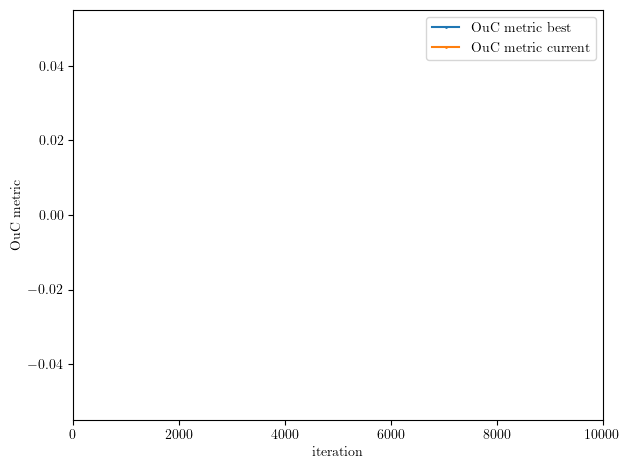

Last losses: [0.13577774167060852, 0.13713200390338898, 0.14402952790260315, 0.1575046181678772, 0.17263102531433105, 0.1878802478313446, 0.19997182488441467, 0.20667943358421326, 0.21188625693321228, 0.21423858404159546]


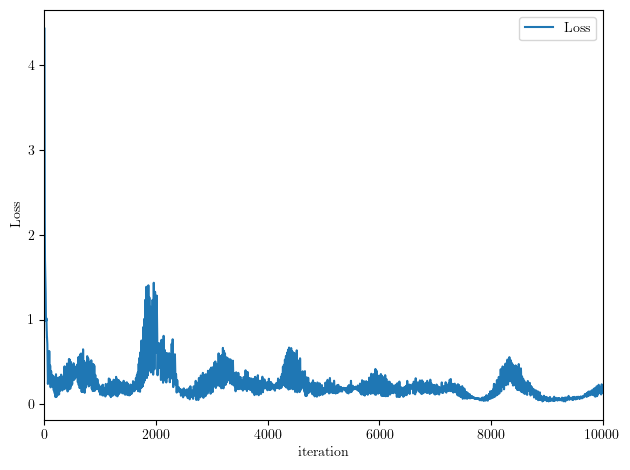

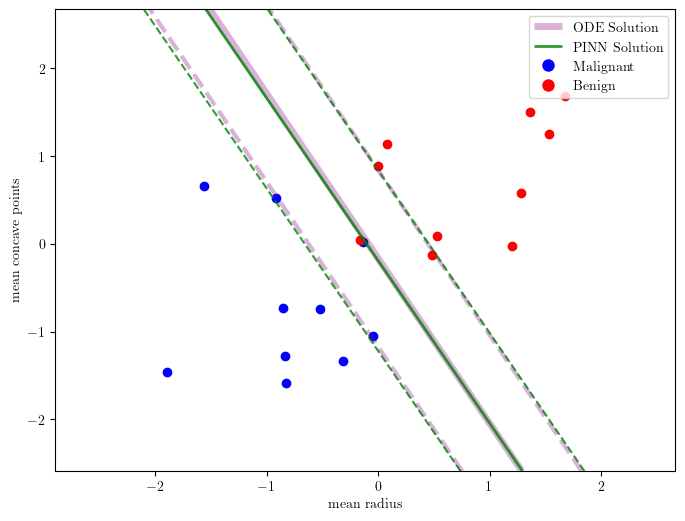

Variables: [-1.8004737  -0.97256255 -0.19209401 -0.12293801  0.09597427  0.02957497
  0.09127461 -0.00499646 -0.00456535 -0.08401307  0.9688792   1.092351
 -0.05479203  0.11365312 -0.012541    0.02166541 -0.04832108 -0.15099292
 -0.13522133  0.05729993 -0.06418999 -0.04335356  0.09174533]
Constraints: [-0.35463277 -0.03640448 -0.25752956 -0.77375245 -1.5539831   0.07766858
 -0.34191632 -0.01236098 -0.02410985 -3.1093833  -2.164661   -3.6333852
  0.01900491 -1.2745026  -1.7005745   0.09288655 -1.1144773  -3.7676206
 -3.0453894  -1.073426    0.12293801 -0.09597427 -0.02957497 -0.09127461
  0.00499646  0.00456535  0.08401307 -0.9688792  -1.092351    0.05479203
 -0.11365312  0.012541   -0.02166541  0.04832108  0.15099292  0.13522133
 -0.05729993  0.06418999  0.04335356 -0.09174533]
objective pinn: 20.458723 epsion pinn: 1
w:  [-1.8004737  -0.97256255] b:  -0.19209401
PINN hyperplane similarity: 0.0011092249361742412
>>>> ITERATION: 5


Time: 0.2643704414367676
objective: 22.67798 lim: 0.1
objective: 22.67798
w:  [-1.87250757 -1.00649589] b:  -0.1827558690686431
hyperplane similarity: 0.0050711530234964775
Dual variables (alpha): [-1.87250757 -1.00649589 -0.18275587 -0.0000005   0.01999136  0.00000533
  0.00000029 -0.00000474  0.01215199  0.0000071   0.93450609  1.09136067
 -0.00000265  0.00000063  0.00000738 -0.00943457  0.00000357  0.00000142
 -0.00676744 -0.00000049 -0.00000216  0.00000775  0.00000064]
Constraints: [-0.55000645  0.0183534  -0.25960076 -0.76017165 -1.6720212   0.01208831
 -0.46031687  0.00314954 -0.0031737  -3.307556   -2.1531942  -3.841562
 -0.00786903 -1.3988658  -1.974769   -0.05582349 -1.1528796  -3.999747
 -3.2278566  -1.0812458   0.0000005  -0.01999136 -0.00000533 -0.00000029
  0.00000474 -0.01215199 -0.0000071  -0.9345061  -1.0913607   0.00000265
 -0.00000063 -0.00000738  0.00943457 -0.00000357 -0.00000142  0.00676744
  0.00000049  0.00000216 -0.00000775 -0.00000064]
>>> Feasible with epsilon

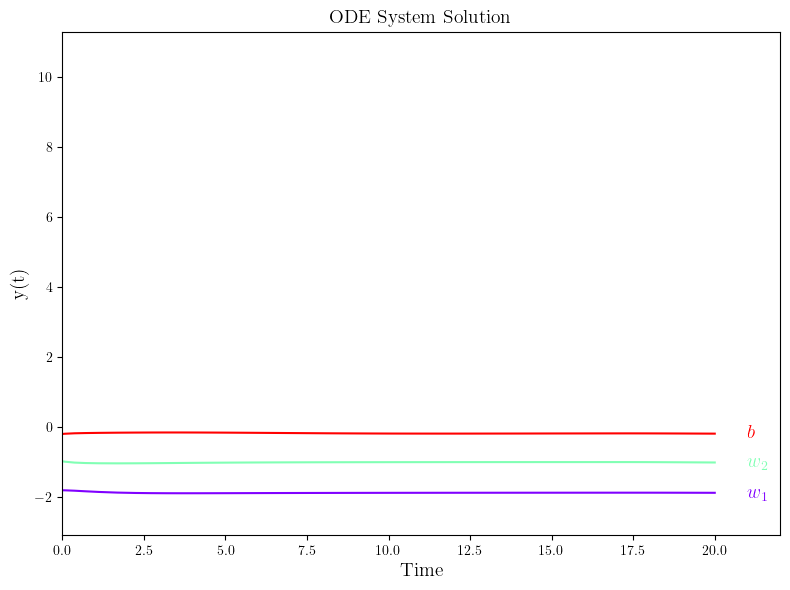

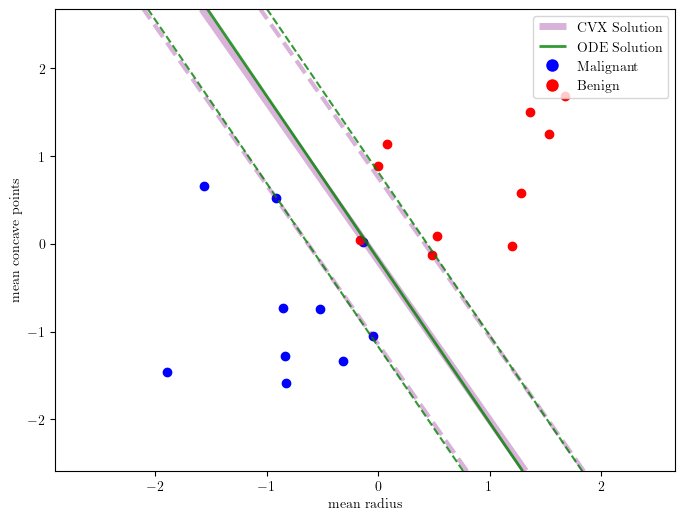

epsilon: inf time: 1161.6480150222778 iterations: 10000


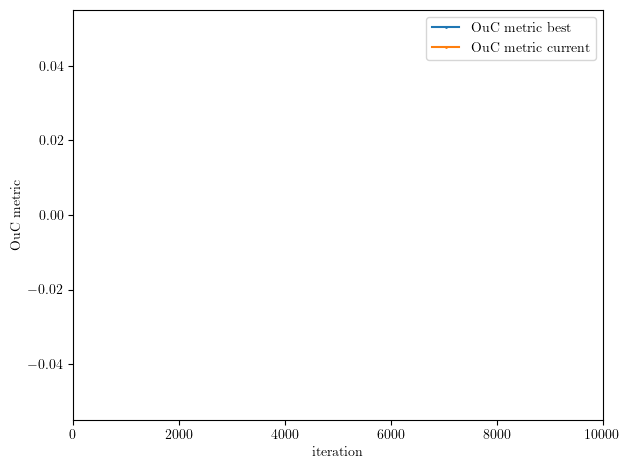

Last losses: [0.2345058023929596, 0.20923152565956116, 0.19980400800704956, 0.21058130264282227, 0.231764554977417, 0.25912654399871826, 0.27650904655456543, 0.29096829891204834, 0.2862502336502075, 0.28866246342658997]


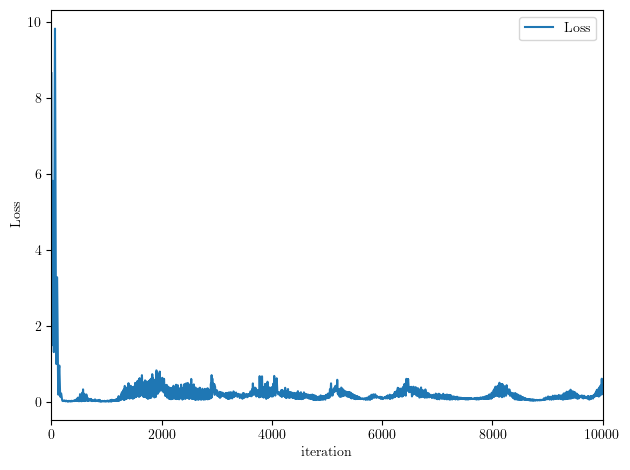

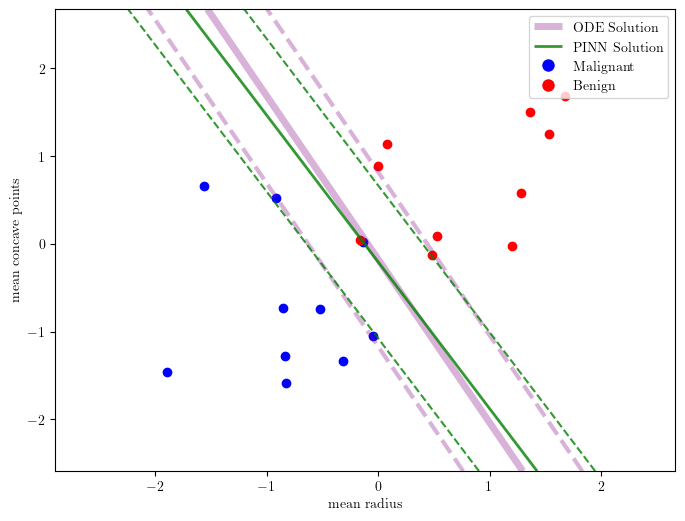

Variables: [-1.9200709  -1.1490979  -0.24265869 -0.08397362  0.08603931  0.07582864
 -0.14237392  0.12110926 -0.0403097  -0.03607855  0.95957863  1.0594344
 -0.11686745  0.02423197 -0.20267354  0.11209647 -0.03605001  0.01846513
  0.09308892  0.0715633   0.19098191  0.00823244  0.02772246]
Constraints: [-0.53720385 -0.11272036 -0.43359104 -0.76345396 -1.9552389  -0.02828666
 -0.64932644  0.03409351 -0.02878626 -3.5010383  -2.3799455  -3.877562
 -0.03956487 -1.4759524  -2.1995254  -0.34192064 -1.3091059  -4.5693426
 -3.574013   -1.0299778   0.08397362 -0.08603931 -0.07582864  0.14237392
 -0.12110926  0.0403097   0.03607855 -0.95957863 -1.0594344   0.11686745
 -0.02423197  0.20267354 -0.11209647  0.03605001 -0.01846513 -0.09308892
 -0.0715633  -0.19098191 -0.00823244 -0.02772246]
objective pinn: 24.404007 epsion pinn: 1
w:  [-1.9200709 -1.1490979] b:  -0.24265869
PINN hyperplane similarity: 0.006505890522194718
>>>> ITERATION: 6
Time: 0.14872479438781738
objective: 22.632671 lim: 0.01
ob

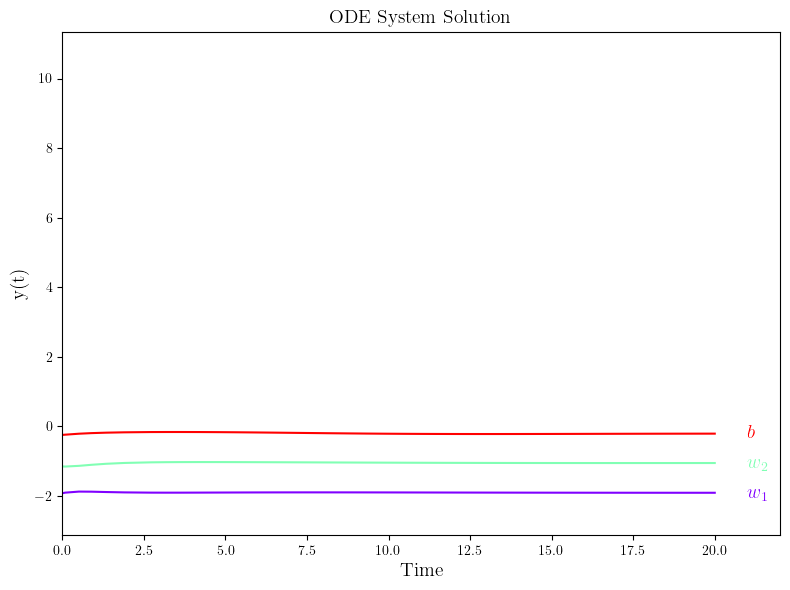

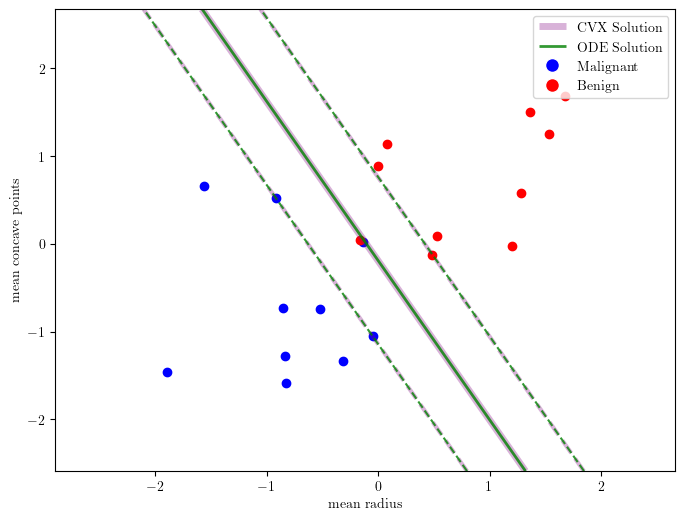

epsilon: inf time: 1082.27454662323 iterations: 10000


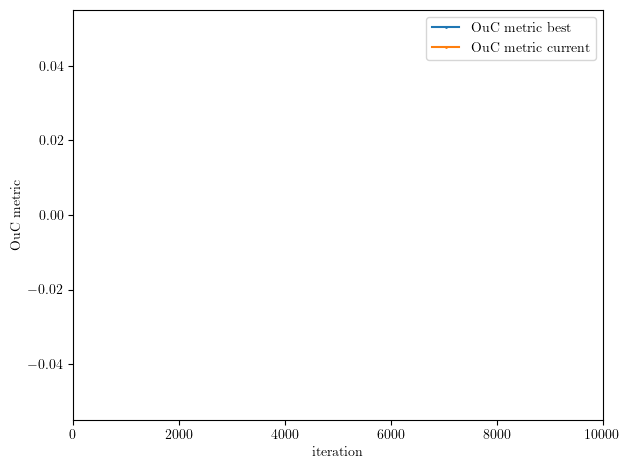

Last losses: [0.17841306328773499, 0.18321499228477478, 0.18491142988204956, 0.18561232089996338, 0.17154255509376526, 0.16473469138145447, 0.15270276367664337, 0.14238205552101135, 0.138036847114563, 0.13326281309127808]


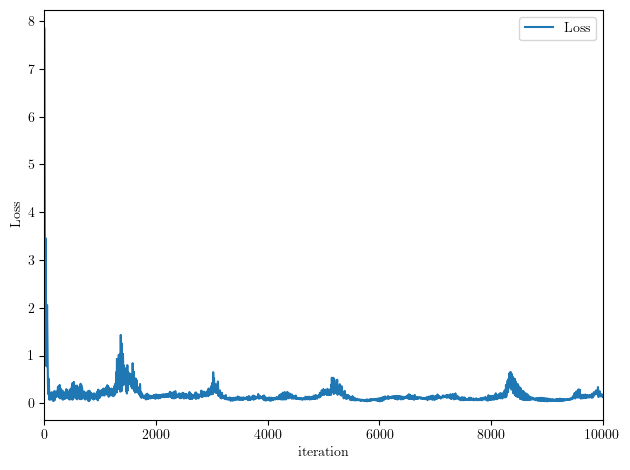

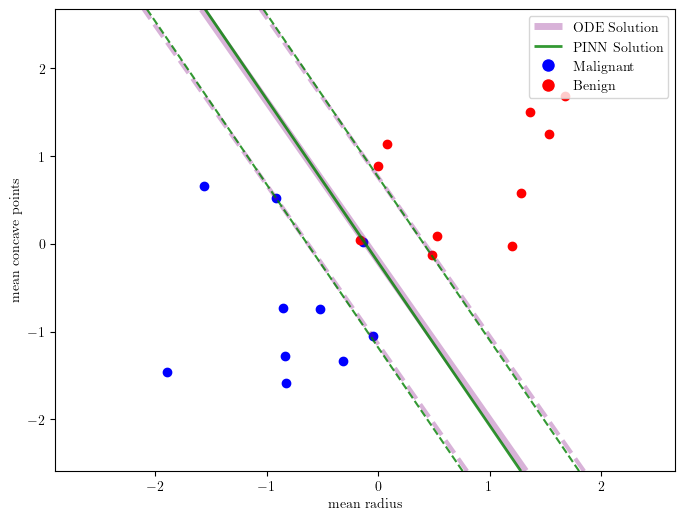

Variables: [-1.914711   -1.0307713  -0.22290683 -0.04009395  0.15397057  0.10849243
  0.10076697  0.07656471 -0.05384641  0.1345591   1.0414371   0.95597994
  0.00582936  0.01152802 -0.13071047 -0.04297496  0.02818099  0.04701778
  0.03203116  0.15714946  0.05591679  0.0747813   0.13910723]
Constraints: [-0.509999   -0.1731327  -0.4326574  -0.86670077 -1.7748137   0.09045073
 -0.6656178  -0.06912295  0.0981013  -3.4484851  -2.2727344  -3.7862568
  0.03959586 -1.5171003  -2.0553277  -0.15601636 -1.3236786  -4.207053
 -3.4363332  -1.2301875   0.04009395 -0.15397057 -0.10849243 -0.10076697
 -0.07656471  0.05384641 -0.1345591  -1.0414371  -0.95597994 -0.00582936
 -0.01152802  0.13071047  0.04297496 -0.02818099 -0.04701778 -0.03203116
 -0.15714946 -0.05591679 -0.0747813  -0.13910723]
objective pinn: 30.921175 epsion pinn: 1
w:  [-1.914711  -1.0307713] b:  -0.22290683
PINN hyperplane similarity: 0.003254929671768464
>>>> ITERATION: 7
Time: 0.18447351455688477


objective: 22.629732 lim: 0.001
objective: 22.629732
w:  [-1.90919407 -1.05366069] b:  -0.20919428996093137
hyperplane similarity: 5.9165521480566974e-05
Dual variables (alpha): [-1.90919407 -1.05366069 -0.20919429  0.00000408  0.00006481 -0.00000473
 -0.00000896 -0.00000406 -0.00051286 -0.00000299  0.95965308  1.06617358
  0.00000239  0.00000236  0.00000892 -0.00015089  0.00000442 -0.00000139
 -0.00000763 -0.0000038   0.00000413 -0.00000536 -0.0000031 ]
Constraints: [-0.57793695  0.00001942 -0.30968553 -0.80842125 -1.7365713  -0.00042336
 -0.54290354  0.00018753 -0.0001762  -3.4489734  -2.2535822  -3.9536536
 -0.00005858 -1.4680073  -2.053806   -0.13064545 -1.1921867  -4.1666126
 -3.3746378  -1.0811987  -0.00000408 -0.00006481  0.00000473  0.00000896
  0.00000406  0.00051286  0.00000299 -0.9596531  -1.0661736  -0.00000239
 -0.00000236 -0.00000892  0.00015089 -0.00000442  0.00000139  0.00000763
  0.0000038  -0.00000413  0.00000536  0.0000031 ]
>>> Feasible with epsilon: 0.001 objective

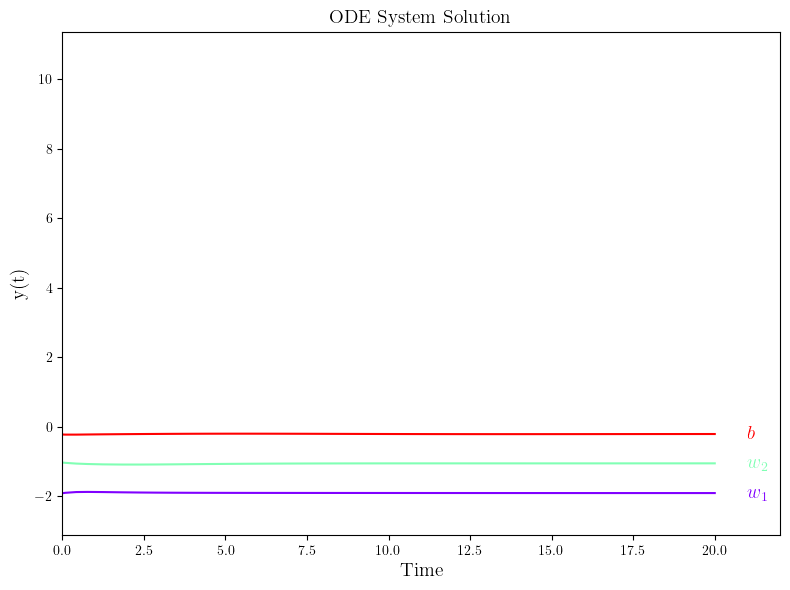

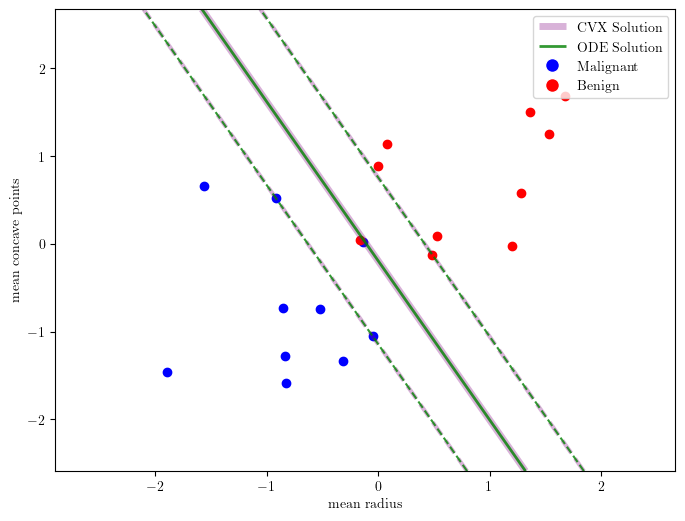

epsilon: inf time: 1156.4295432567596 iterations: 10000


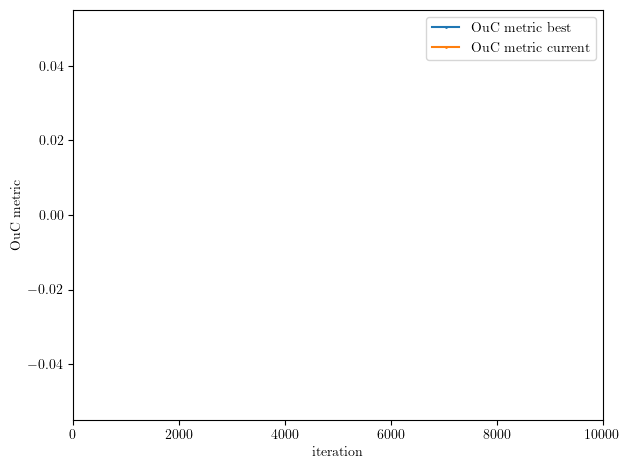

Last losses: [0.07905197888612747, 0.07099813967943192, 0.06598024815320969, 0.06482010334730148, 0.0668841302394867, 0.07409419119358063, 0.08442572504281998, 0.09468424320220947, 0.10410616546869278, 0.11510425060987473]


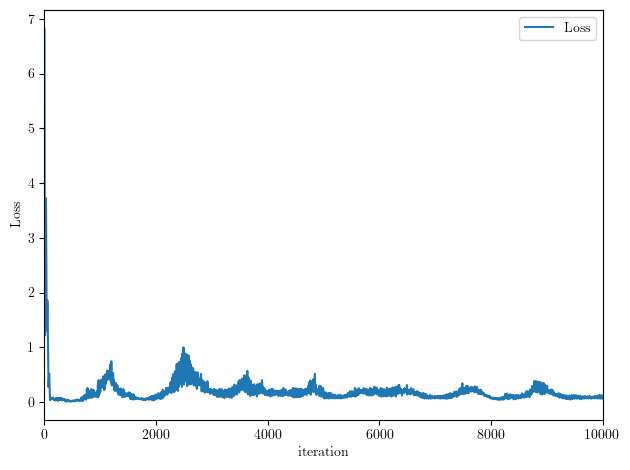

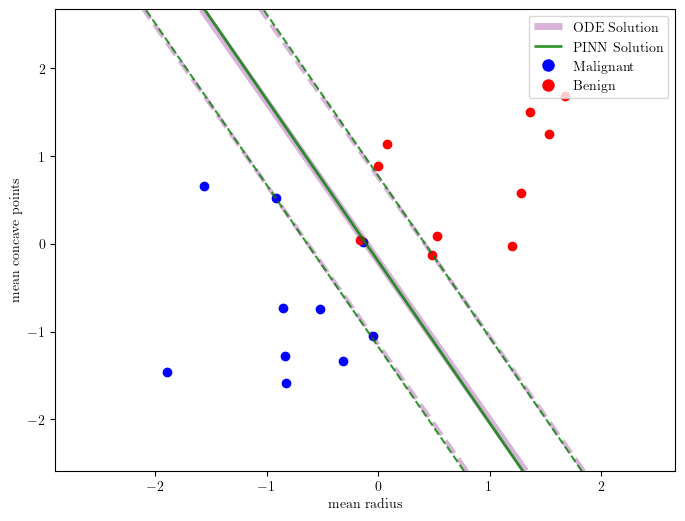

Variables: [-1.8925024  -1.0280243  -0.2091372  -0.09158128 -0.00953758 -0.08016401
 -0.09580658  0.11605895 -0.0400645   0.10231493  0.91920197  0.95988
 -0.10522664  0.06349827 -0.04312919  0.00495287  0.0541505  -0.08288203
  0.0607076   0.07052581  0.00928573 -0.02124455 -0.11041859]
Constraints: [-0.45856658  0.01453441 -0.2183165  -0.6731195  -1.8059579   0.0669563
 -0.61487556  0.04243328  0.1044026  -3.286177   -2.280979   -3.8414428
 -0.00312431 -1.5027766  -1.9163535  -0.16865396 -1.2298167  -4.10494
 -3.2923257  -0.9615649   0.09158128  0.00953758  0.08016401  0.09580658
 -0.11605895  0.0400645  -0.10231493 -0.91920197 -0.95988     0.10522664
 -0.06349827  0.04312919 -0.00495287 -0.0541505   0.08288203 -0.0607076
 -0.07052581 -0.00928573  0.02124455  0.11041859]
objective pinn: 19.124413 epsion pinn: 1
w:  [-1.8925024 -1.0280243] b:  -0.2091372
PINN hyperplane similarity: 0.000538411108821385
>>>> ITERATION: 8
Time: 0.17118477821350098
objective: 22.638756 lim: 0.001
objecti

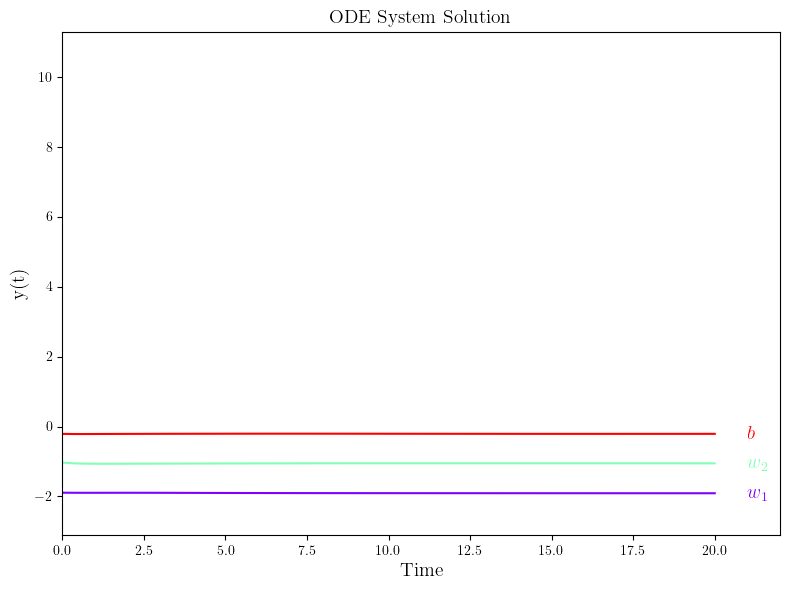

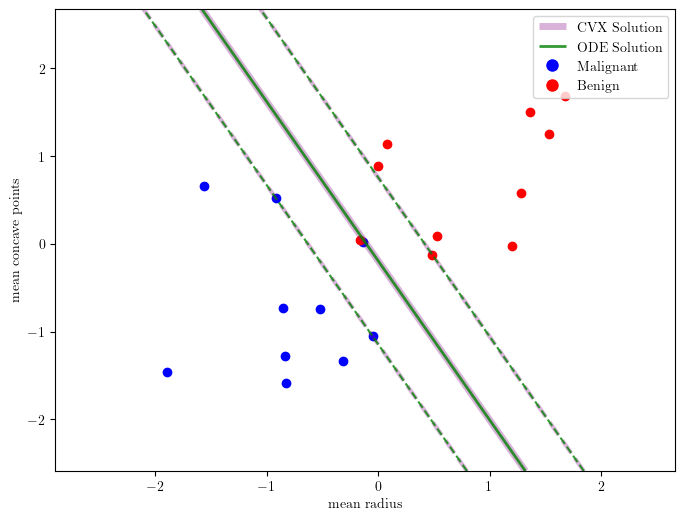

epsilon: inf time: 1082.57266330719 iterations: 10000


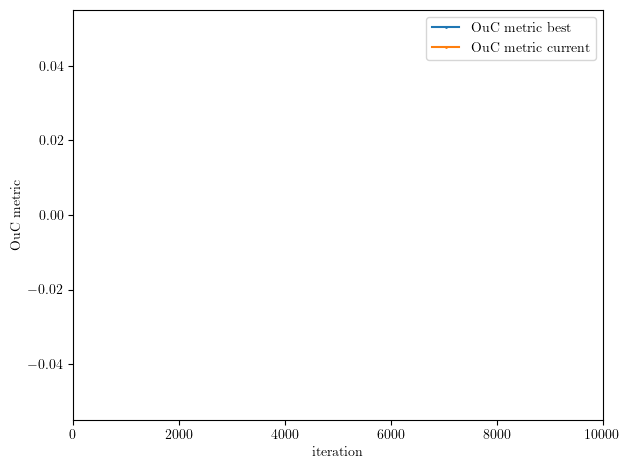

Last losses: [0.08038385212421417, 0.08759649842977524, 0.09259851276874542, 0.10232081264257431, 0.11057582497596741, 0.11795738339424133, 0.12116439640522003, 0.1273130476474762, 0.12580180168151855, 0.12654228508472443]


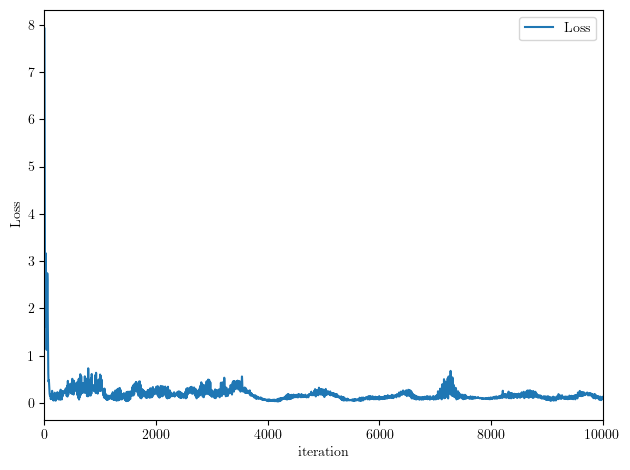

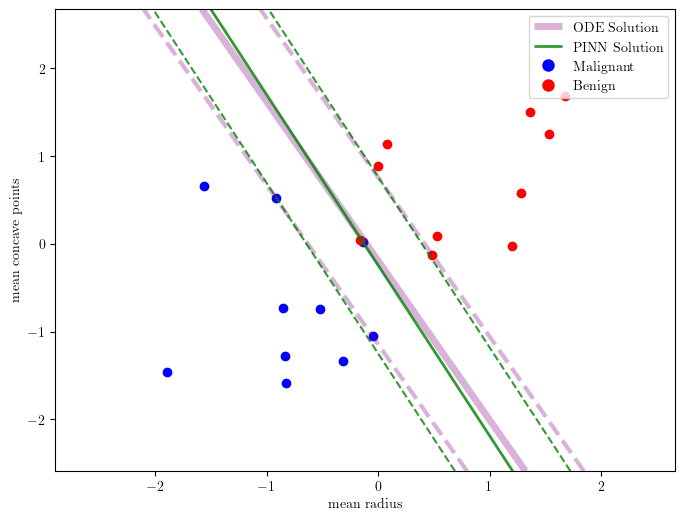

Variables: [-1.9318646  -0.994689   -0.24878544 -0.03682007  0.07511365  0.03914478
 -0.07882746  0.06424374  0.00524116 -0.01671742  0.91507566  1.0000802
 -0.00990366  0.0440381   0.06649376 -0.00925817  0.06751674  0.07578866
  0.06599255 -0.04584198 -0.07867789  0.05686528  0.03531654]
Constraints: [-0.4695685  -0.13296501 -0.39482942 -0.61856145 -1.7049003   0.09436075
 -0.50054157  0.07996628  0.03235335 -3.4400306  -2.332336   -3.9374328
 -0.00262131 -1.603798   -2.0151515  -0.18366395 -1.0832107  -4.0664597
 -3.4135044  -1.1509067   0.03682007 -0.07511365 -0.03914478  0.07882746
 -0.06424374 -0.00524116  0.01671742 -0.91507566 -1.0000802   0.00990366
 -0.0440381  -0.06649376  0.00925817 -0.06751674 -0.07578866 -0.06599255
  0.04584198  0.07867789 -0.05686528 -0.03531654]
objective pinn: 24.709396 epsion pinn: 0.1
w:  [-1.9318646 -0.994689 ] b:  -0.24878544
PINN hyperplane similarity: 0.009426746423235183


In [14]:
ITERATIONS = 2000
LR = 0.01
ip = np.zeros(NY)
ip[:nw + nb] = 1.0

for i in range(8):
    print('>>>> ITERATION:', i+1)
    res, pinn_obj, lastIter = iteration(ip)
    wb_pinn = res[:nw+1]
    if lastIter:
        print('>>>> Results obtained, OuC: ', pinn_obj)
        break
    ip = res
    ITERATIONS = 10000
    LR = 0.001